<a href="https://colab.research.google.com/github/rahmansadiqgit/Thesis_Work/blob/master/XGBoost1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading DataSet

In [ ]:
import kagglehub
path = kagglehub.dataset_download("saqibgulzarbhat/uci-phishing-detection-dataset")

100%|██████████| 15.9M/15.9M [00:00<00:00, 242MB/s]

Extracting files...


In [ ]:
!ls $path

PhiUSIIL_Phishing_URL_Dataset.csv


In [ ]:
import pandas as pd
df = pd.read_csv(path+'/PhiUSIIL_Phishing_URL_Dataset.csv')

In [ ]:
# Show full rows, full columns, full cell content
pd.set_option('display.max_rows', None)         # Show all rows
pd.set_option('display.max_columns', None)      # Show all columns
pd.set_option('display.max_colwidth', None)     # Show full content of each cell
pd.set_option('display.width', None)

In [ ]:
df.columns

Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'URLSimilarityIndex', 'CharContinuationRate',
       'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOf

In [ ]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [ ]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
import re
from urllib.parse import urlparse
import tldextract
import pandas as pd

def extract_url_features(url):
    """
    Extract URL features matching the UCI Phishing Detection Dataset.
    """
    url = url.strip()
    features = {}

    # 1. URLLength
    features['URLLength'] = len(url) - 1

    # 2. IsHTTPS
    features['IsHTTPS'] = 1 if url.lower().startswith('https://') else 0

    # Parse URL
    parsed = urlparse(url)
    ext = tldextract.extract(url)

    # 3. DomainLength
    full_domain = parsed.netloc
    features['DomainLength'] = len(full_domain)

    # 4. TLD
    tld = ext.suffix.split('.')[-1] if ext.suffix else ''
    features['TLD'] = tld
    features['TLDLength'] = len(tld)

    # 5. NoOfSubDomain
    domain_parts = parsed.netloc.split('.')
    features['NoOfSubDomain'] = max(0, len(domain_parts) - 2)

    # 6. IsDomainIP
    features['IsDomainIP'] = 1 if re.match(r'^(\d{1,3}\.){3}\d{1,3}$', ext.domain) else 0

    # URL body without protocol and www
    url_body = url.split("://", 1)[-1]
    if url_body.startswith("www."):
        url_body = url_body[4:]

    # Letters and digits
    num_letters = sum(c.isalpha() for c in url_body)
    features['NoOfLettersInURL'] = num_letters - 1
    features['LetterRatioInURL'] = round(((num_letters - 1) / len(url)) * 1.04, 3)

    num_digits = sum(c.isdigit() for c in url_body)
    features['NoOfDegitsInURL'] = num_digits
    features['DegitRatioInURL'] = round(num_digits / features['URLLength'], 6)

    # Special characters
    features['NoOfEqualsInURL'] = url.count('=')
    features['NoOfQMarkInURL'] = url.count('?')
    features['NoOfOtherSpecialCharsInURL'] = sum(not c.isalnum() for c in url_body)
    features['SpacialCharRatioInURL'] = round(features['NoOfOtherSpecialCharsInURL'] / features['URLLength'], 3)

    return features



In [ ]:
url_features = extract_url_features("https://www.facebook.com")
url_features_column = list(url_features.keys())
url_features_column

['URLLength',
 'IsHTTPS',
 'DomainLength',
 'TLD',
 'TLDLength',
 'NoOfSubDomain',
 'IsDomainIP',
 'NoOfLettersInURL',
 'LetterRatioInURL',
 'NoOfDegitsInURL',
 'DegitRatioInURL',
 'NoOfEqualsInURL',
 'NoOfQMarkInURL',
 'NoOfOtherSpecialCharsInURL',
 'SpacialCharRatioInURL']

In [ ]:
X = df[url_features_column]
y = df['label']

In [ ]:
class TLDEncoder:
    def __init__(self):
        self.classes = []
        self.unknown_id = -1

    def fit(self, series):
        vals = series.astype(str).unique().tolist()
        self.classes = sorted(vals)
        self.map = {v: i for i, v in enumerate(self.classes)}

    def transform(self, series):
        return series.astype(str).apply(
            lambda x: self.map.get(x, self.unknown_id)
        )

    def fit_transform(self, series):
        self.fit(series)
        return self.transform(series)


In [ ]:
# Create encoder instance
tld_encoder = TLDEncoder()

# Fit on training TLD column
X["TLD"] = tld_encoder.fit_transform(X["TLD"])


/tmp/ipython-input-1500861825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["TLD"] = tld_encoder.fit_transform(X["TLD"])


# Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler


# Initialize scaler
scaler = MinMaxScaler()

# Fit + transform training data
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)


# Split for train and validation

In [ ]:
from sklearn.model_selection import train_test_split
y = df.label.tolist()

X_train, X_valid, y_train, y_valid= train_test_split(
    X_scaled, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)


# Model Creation and Train



In [ ]:
import xgboost as xgb
from xgboost.callback import EarlyStopping

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.05,
    'eval_metric': 'logloss'
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    callbacks=[EarlyStopping(rounds=40, save_best=True)],
    verbose_eval=False   # <-- suppress log output
)


# Prediction Method

In [ ]:
# --- Data handling ---
import pandas as pd
import numpy as np

# --- Machine learning / metrics ---
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- XGBoost ---
import xgboost as xgb


def XGBoost1_predict(urls , test_y):
  test_X = [extract_url_features(x) for x in urls]

  test_X = pd.DataFrame(test_X,columns=url_features_column)

  # encode string
  test_X["TLD"] = tld_encoder.transform(test_X["TLD"])

  #scale for as it doing in training
  test_X= pd.DataFrame(
    scaler.transform(test_X),
    columns=test_X.columns
  )

  # Convert test set to DMatrix
  dtest = xgb.DMatrix(test_X)
   # Predict
  pred = bst.predict(dtest)

  # If you want binary labels
  pred_labels = (pred > 0.5).astype(int)


  # ✅ 1. Calculate accuracy
  accuracy = accuracy_score(test_y, pred_labels)
  print("Accuracy : " , accuracy)

  # ✅ 2. Calculate confusion matrix
  cm = confusion_matrix(test_y, pred_labels)

  # ✅ 3. Calculate precision, recall, F1
  precision = precision_score(test_y, pred_labels)
  recall = recall_score(test_y, pred_labels)
  f1 = f1_score(test_y, pred_labels)

  # ✅ 4. Plot confusion matrix
  plt.figure(figsize=(7,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
  plt.show()






# Own DataSet Test

In [ ]:
df.columns

Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'URLSimilarityIndex', 'CharContinuationRate',
       'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOf

Accuracy :  0.9978201403761742


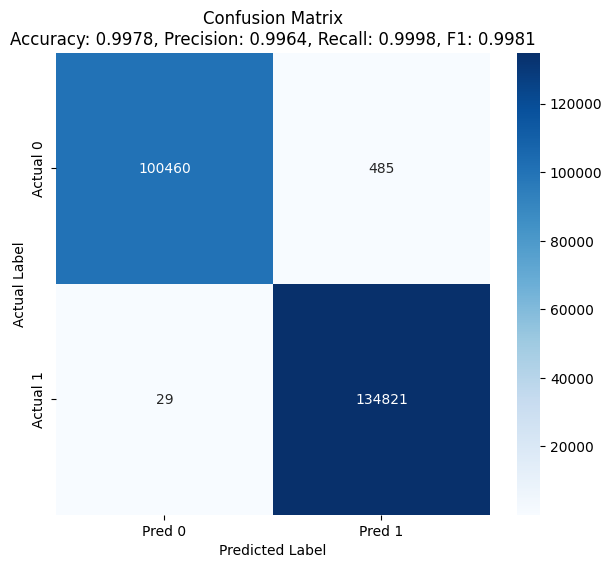

In [ ]:
XGBoost1_predict(df.URL , df.label)

# Manual Test by ChatGpt

In [ ]:
test_urls = [
    "https://www.google.com",
    "https://www.facebook.com",
    "https://www.amazon.com",
    "https://www.microsoft.com",
    "https://www.netflix.com",
    "https://www.github.com",
    "https://www.twitter.com",
    "https://www.wikipedia.org",
    "https://www.apple.com",
    "https://www.stackoverflow.com",
    "http://secure-login-paypal.com.verify-user-info.cc/login",
    "http://bankofamerica.secure-alerts-update.net/account",
    "https://facebook.com.security-check-verify.ga/login",
    "http://amazon-login-support-refund.co/account/verify",
    "https://gmail.com.recovery-support-team.ml/verify",
    "http://microsoft-update-security-center.info/login",
    "https://appleid-login-auth-service.ru/secure",
    "http://dropbox-file-share-download.xyz/secure-login",
    "https://netflix-billing-update-support.tk/confirm",
    "http://icici-bank-update-alerts.online/login"
]

test_y = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,0,0,0,0,0,0,0,0,0,0]





Accuracy :  1.0


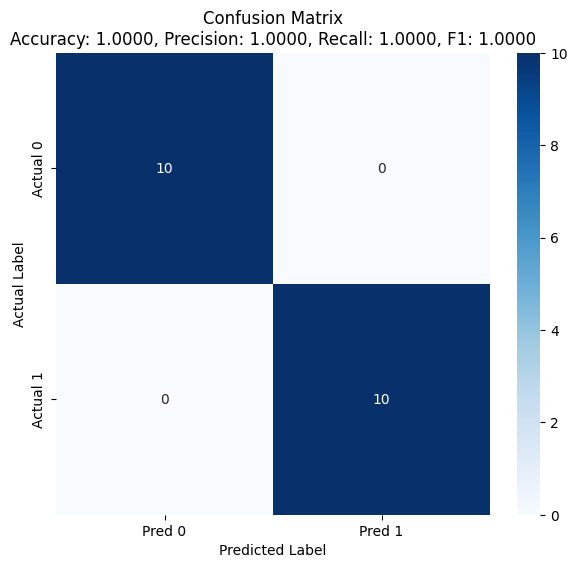

In [ ]:
XGBoost1_predict(test_urls, test_y)

# Testing by Phishing Websites Detection

In [ ]:
import kagglehub
path = kagglehub.dataset_download("akshaya1508/phishing-websites-detection")

In [ ]:
import pandas as pd
new_df = pd.read_excel(path+"/Detection.xlsx")


In [ ]:
new_df['Result'] = new_df['Result'].replace(-1, 0)


Accuracy :  0.6407142857142857


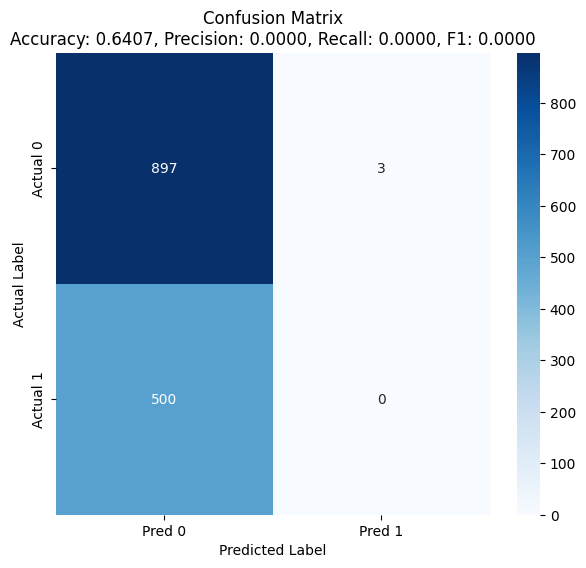

In [ ]:
XGBoost1_predict(new_df.URL , new_df.Result)

#Test by Neural Network DataSet

In [ ]:
import kagglehub
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

100%|██████████| 1.01M/1.01M [00:00<00:00, 81.9MB/s]

Extracting files...


In [ ]:
import pandas as pd

N_df = pd.read_csv(path + "/dataset_phishing.csv")

In [ ]:
N_df["status"] = df["status"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

In [ ]:
N_df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,0
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


Accuracy :  0.5


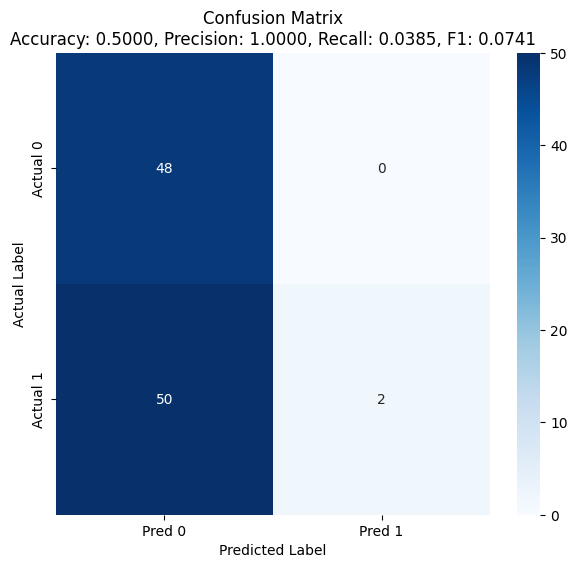

In [ ]:
XGBoost1_predict(N_df.url.head(100) ,N_df.status.head(100))

# Checking by ChatGpt 5000 urls

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving url_dataset_5000.csv to url_dataset_5000.csv


In [ ]:
ls

drive/  sample_data/  url_dataset_5000.csv


In [ ]:
CG_df = pd.read_csv("url_dataset_5000.csv")

In [ ]:
CG_df.head()

,url,label
0,https://mcrravlgw.info/login/ileh?redirect=gepgim#yia,phishing
1,https://aghlsktp.app/nargwy/eoadkkhikp,legitimate
2,https://lmpcfqmgc.net/bvlh%25wur%25fz%25sfyh/wiw.php?,phishing
3,https://ncnk.co/login/flhfb?redirect=qjkc,phishing
4,http://iamzr.io/bdqv/duyq/qyqmeusxpp?page=jQw7v1&q=gy9qHubs&id=rtMi0580xRfWaUOFE,legitimate


In [ ]:
CG_df["label"] = CG_df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-277365720.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CG_df["label"] = CG_df["label"].replace({


In [ ]:
CG_df.head()

,url,label,status
0,https://mcrravlgw.info/login/ileh?redirect=gepgim#yia,0,1
1,https://aghlsktp.app/nargwy/eoadkkhikp,1,1
2,https://lmpcfqmgc.net/bvlh%25wur%25fz%25sfyh/wiw.php?,0,1
3,https://ncnk.co/login/flhfb?redirect=qjkc,0,1
4,http://iamzr.io/bdqv/duyq/qyqmeusxpp?page=jQw7v1&q=gy9qHubs&id=rtMi0580xRfWaUOFE,1,1


Accuracy :  0.501


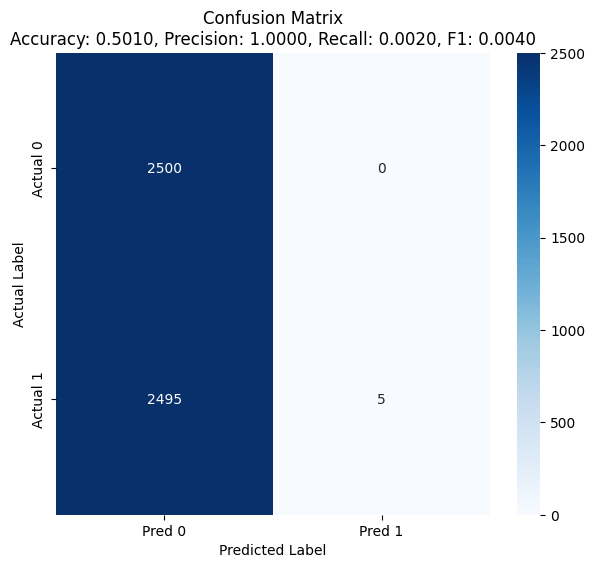

In [ ]:
XGBoost1_predict(CG_df.url , CG_df.label)

# Checking by Claude 5000 urls

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
!ls

In [ ]:
Claude_df = pd.read_csv("phishing_url_dataset_5000.csv")

In [ ]:
Claude_df.head()

In [ ]:
Claude_df["label"] = Claude_df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-2564128249.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Claude_df["label"] = Claude_df["label"].replace({


In [ ]:
Claude_shuffled = Claude_df.sample(frac=1, random_state=2).reset_index(drop=True)


Accuracy: 0.8022
Confusion Matrix:
 [[2237  263]
 [ 726 1774]]
Precision: 0.8709, Recall: 0.7096, F1-score: 0.7820


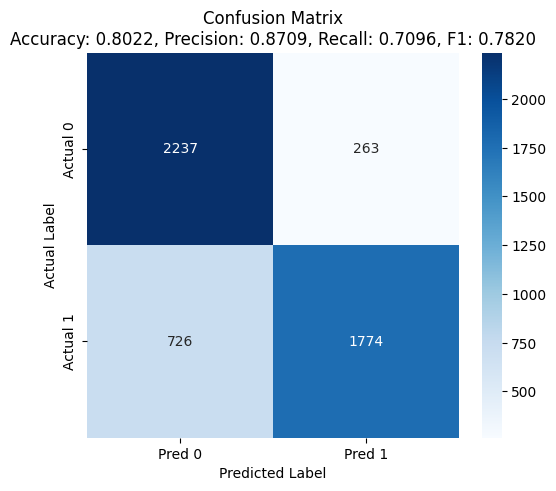

In [ ]:
Neural_Network_predict(Claude_shuffled.url , Claude_shuffled.label)